In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
import scipy.signal
import heapq
from sklearn import preprocessing

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [3]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
read_temp=scipy.io.loadmat(matpath + 'data2_snr.mat')
T_SBC_R=read_temp['T_SBC_R']
T_SBC=read_temp['T_SBC']
SNR=read_temp['SNR']
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1, 3)
[r2, K, I, S] = np.shape(S_est)
S_abs = np.zeros((r2, I*2, S))
for i in range(r2):
    for k in range(S):
        for j in range(I):
            S_abs[i, j, k] = S_est[i, 0, j, k]
            S_abs[i, I+j, k] = S_est[i, 1, j, k]    

S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est[:, :, 0])

#r2 = 1000, for the number of data
#K = 2, for the number of sources
#I = 120, for the number of DOAs
#S =31, for the number of SNRs

[r2,c,S]=np.shape(R_est)
[r2,I,S]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}, S: {S}')
print(f'S_est: {S_est.shape}, S_abs: {S_abs.shape}' 
      f'\nS_label: {S_label.shape}, S_label1: {S_label1.shape}'
      f'\nR_est: {R_est.shape}')


DOA = np.arange(I)-60
L = I

r2: 1000, I: 120, c: 56, S: 31
S_est: (1000, 2, 120, 31), S_abs: (1000, 240, 31)
S_label: (1000, 120, 31), S_label1: (1000, 120, 1, 31)
R_est: (1000, 56, 31)


In [4]:
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')
cnntanh = torch.load(pthpath + 'cnntanh.pth')
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')


In [5]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_nobatchnorm(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

cnnrelu_nobatchnorm = torch.load(pthpath + 'cnnrelu_nobatchnorm.pth')
cnntanh_nobatchnorm = torch.load(pthpath + 'cnntanh_nobatchnorm.pth')
cnnsigmoid_nobatchnorm = torch.load(pthpath + 'cnnsigmoid_nobatchnorm.pth')

In [6]:
class DNN(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*I, int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*I/3), int(4*I/9)), nn.BatchNorm1d(int(4*I/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*I/9), int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*I/3), I), nn.BatchNorm1d(I), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
dnnrelu = torch.load(pthpath + 'dnnrelu.pth')
dnntanh = torch.load(pthpath + 'dnntanh.pth')
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [7]:
class DNN_nobatchnorm(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
    
dnnrelu_nobatchnorm = torch.load(pthpath + 'dnnrelu_nobatchnorm.pth')
dnntanh_nobatchnorm = torch.load(pthpath + 'dnntanh_nobatchnorm.pth')
dnnsigmoid_nobatchnorm = torch.load(pthpath + 'dnnsigmoid_nobatchnorm.pth')

In [8]:
def Test(model, inputx, k, flag=1):
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            if flag == 0:
                x = np.zeros((K, I))
                x[:, :] = inputx[i, :, :, k]
                #atttntion: the input of the model should be a tensor which is in the shape of (batch_size, channel, length)
                x = torch.from_numpy(x.reshape(1, K, I)).float().to('cpu')
            elif flag == 1:
                x = np.zeros(K*I)
                x[:] = inputx[i, :, k]
                x = torch.from_numpy(x.reshape(1, -1)).float().to('cpu')
            x = x.to(device)
            # print(np.shape(x))
            y = model(x)
            y = y.cpu().numpy()
            ls.append(y)
    predict = np.array(ls)
    return np.squeeze(predict)

In [9]:
test_cnn_low=np.zeros((r2,1))


def predict2doaarray(model, input, flag):
    predict = np.zeros((r2, I, S))
    for i in range(S):
        predict1 = Test(model, input, i, flag)
        
        predict[:, :, i] = predict1
    return predict

doa_dnntanharray = predict2doaarray(dnntanh, S_abs, 1)
doa_dnnreluarray = predict2doaarray(dnnrelu, S_abs, 1)
doa_dnnsigmoidarray = predict2doaarray(dnnsigmoid, S_abs, 1)
doa_dnntanharray_nobatchnorm = predict2doaarray(dnntanh_nobatchnorm, S_abs, 1)
doa_dnnreluarray_nobatchnorm = predict2doaarray(dnnrelu_nobatchnorm, S_abs, 1)
doa_dnnsigmoidarray_nobatchnorm = predict2doaarray(dnnsigmoid_nobatchnorm, S_abs, 1)
doa_dcntanharray = predict2doaarray(cnntanh, S_est, 0)
doa_dcnreluarray = predict2doaarray(cnnrelu, S_est, 0)
doa_dcnsigmoidarray = predict2doaarray(cnnsigmoid, S_est, 0)
doa_dcnreluarray_nobatchnorm = predict2doaarray(cnnrelu_nobatchnorm, S_est, 0)
doa_dcnsigmoidarray_nobatchnorm = predict2doaarray(cnnsigmoid_nobatchnorm, S_est, 0)
doa_dcntanharray_nobatchnorm = predict2doaarray(cnntanh_nobatchnorm, S_est, 0)


In [30]:
def DOAarray2peak(predict, height = 0.1, nodetect = 0):
    #flag==0 for CNN, flag==1 for DNN
    peak = np.zeros((K, r2, S))
    for i in range(r2):
        for m in range(S):
            li = []
            li = predict[i, :, m]
            peaks_st = np.zeros((K))
            peaks_st = peaks_st + nodetect
            peaks,_ = scipy.signal.find_peaks(li, height=height)
            maxamp = heapq.nlargest(K, li[peaks])
            
            rank = np.zeros(np.shape(maxamp)[0])
            for s in range(np.shape(maxamp)[0]):
                rank[s] = np.where(li==maxamp[s])[0][0]
            
            if len(peaks) == K:
                peaks_st = peaks
            elif len(peaks) == 0:
                peaks_st = peaks_st
            elif len(peaks) < K:
                for t in range(len(peaks)):
                    peaks_st[t] = peaks[t]
            elif len(peaks) > K:
                for j in range(K):
                    peaks_st[j] = rank[j]

            peak[:, i, m] = sorted(peaks_st, reverse=True)
        # if peaks_st[0] > peaks_st[1]:
        #     peak[:,i] = [peaks_st[0], peaks_st[1]]
        # else:
        #     peak[:,i] = [peaks_st[1], peaks_st[0]]
    return peak-60

doa_dnntanh = DOAarray2peak(doa_dnntanharray)
doa_dnnrelu = DOAarray2peak(doa_dnnreluarray)
doa_dnnsigmoid = DOAarray2peak(doa_dnnsigmoidarray)
doa_dnntanh_nobatchnorm = DOAarray2peak(doa_dnntanharray_nobatchnorm)
doa_dnnrelu_nobatchnorm = DOAarray2peak(doa_dnnreluarray_nobatchnorm)
doa_dnnsigmoid_nobatchnorm = DOAarray2peak(doa_dnnsigmoidarray_nobatchnorm)

doa_dcntanh = DOAarray2peak(doa_dcntanharray)
doa_dcnrelu = DOAarray2peak(doa_dcnreluarray)
doa_dcnsigmoid = DOAarray2peak(doa_dcnsigmoidarray)
doa_dcnrelu_nobatchnorm = DOAarray2peak(doa_dcnreluarray_nobatchnorm)
doa_dcnsigmoid_nobatchnorm = DOAarray2peak(doa_dcnsigmoidarray_nobatchnorm)
doa_dcntanh_nobatchnorm = DOAarray2peak(doa_dcntanharray_nobatchnorm)

In [31]:
#change the column
def switchcolumn(inarray):
    a = np.zeros((K, r2, S))
    a[0, :, :] = inarray[1, :, :]
    a[1, :, :] = inarray[0, :, :]
    return a

def caculate_rmse(predictDOApeek):
    predictDOApeek = switchcolumn(predictDOApeek)
    rmse_matrix_power = np.zeros((r2, 1))
    rmse = np.zeros((S, 1))
    for s in range(S):
        for r in range(r2):
            rmse_matrix_power[r] = np.mean(np.square(predictDOApeek[:, r, s] - DOA_train[:, r, s]))
        rmse[s] = np.sqrt(np.mean(rmse_matrix_power))
    return rmse

rmse_dnntanh = caculate_rmse(doa_dnntanh)
rmse_dnnrelu = caculate_rmse(doa_dnnrelu)
rmse_dnnsigmoid = caculate_rmse(doa_dnnsigmoid)
rmse_dnntanh_nobatchnorm = caculate_rmse(doa_dnntanh_nobatchnorm)
rmse_dnnrelu_nobatchnorm = caculate_rmse(doa_dnnrelu_nobatchnorm)
rmse_dnnsigmoid_nobatchnorm = caculate_rmse(doa_dnnsigmoid_nobatchnorm)

rmse_dcntanh = caculate_rmse(doa_dcntanh)
rmse_dcnrelu = caculate_rmse(doa_dcnrelu)
rmse_dcnsigmoid = caculate_rmse(doa_dcnsigmoid)
rmse_dcnrelu_nobatchnorm = caculate_rmse(doa_dcnrelu_nobatchnorm)
rmse_dcnsigmoid_nobatchnorm = caculate_rmse(doa_dcnsigmoid_nobatchnorm)
rmse_dcntanh_nobatchnorm = caculate_rmse(doa_dcntanh_nobatchnorm)

In [32]:
doa_sbl = DOAarray2peak(gamma)
rmse_sbl = caculate_rmse(doa_sbl)

doa_sblr = DOAarray2peak(gamma_R)
rmse_sblr = caculate_rmse(doa_sblr)

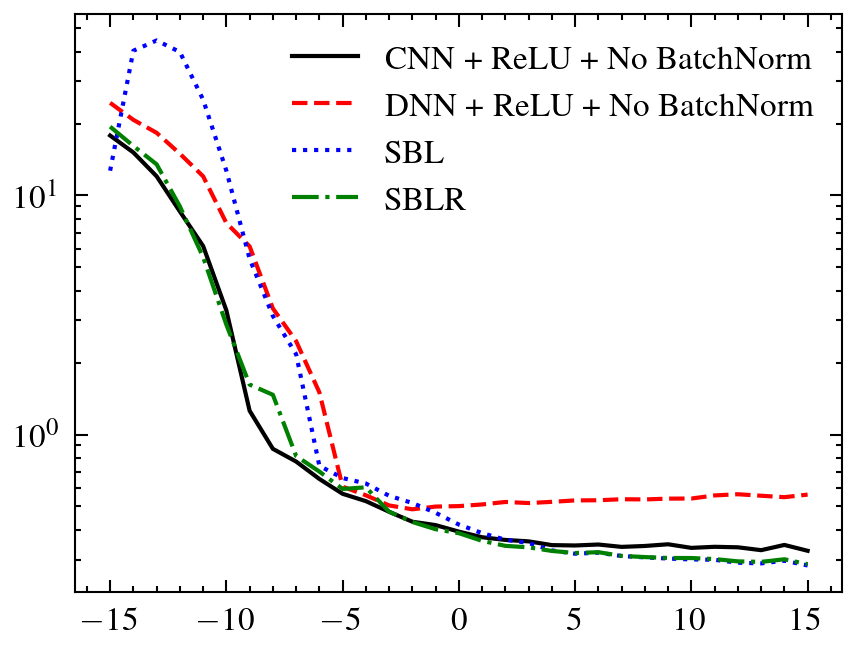

In [41]:
leftrange = -15
rightrange = 15
snr_list = range(leftrange,rightrange+1)
with plt.style.context(['science', 'ieee']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    # plt.ylim([0.1,100])
    # plt.semilogy(snr_list, rmse_dcntanh[leftrange+15:rightrange+16, :], label='CNN + Tanh')
    # plt.semilogy(snr_list, rmse_dcnrelu[leftrange+15:rightrange+16, :], label='CNN + ReLU')
    # plt.semilogy(snr_list, rmse_dcnsigmoid[leftrange+15:rightrange+16, :], label='CNN + Sigmoid')
    
    # plt.semilogy(snr_list, rmse_dcntanh_nobatchnorm[leftrange+15:rightrange+16, :], label='CNN + Tanh + No BatchNorm')
    plt.semilogy(snr_list, rmse_dcnrelu_nobatchnorm[leftrange+15:rightrange+16, :], label='CNN + ReLU + No BatchNorm')
    # plt.semilogy(snr_list, rmse_dcnsigmoid_nobatchnorm[leftrange+15:rightrange+16, :], label='CNN + Sigmoid + No BatchNorm')
    
    # plt.semilogy(snr_list, rmse_dnnrelu[leftrange+15:rightrange+16, :], label='DNN + ReLU')
    # plt.semilogy(snr_list, rmse_dnntanh[leftrange+15:rightrange+16, :], label='DNN + Tanh')
    # plt.semilogy(snr_list, rmse_dnnsigmoid[leftrange+15:rightrange+16, :], label='DNN + Sigmoid')
    
    plt.semilogy(snr_list, rmse_dnnrelu_nobatchnorm[leftrange+15:rightrange+16, :], label='DNN + ReLU + No BatchNorm')
    # plt.semilogy(snr_list, rmse_dnntanh_nobatchnorm[leftrange+15:rightrange+16, :], label='DNN + Tanh + No BatchNorm')
    # plt.semilogy(snr_list, rmse_dnnsigmoid_nobatchnorm[leftrange+15:rightrange+16, :], label='DNN + Sigmoid + No BatchNorm')
    
    plt.semilogy(snr_list, rmse_sbl[leftrange+15:rightrange+16, :], label='SBL')
    plt.semilogy(snr_list, rmse_sblr[leftrange+15:rightrange+16, :], label='SBLR')
    plt.savefig(figurepath + 'SNR_VS_RMSE/Total Rmse.pdf')
    plt.legend()
    plt.show()